In [ ]:
from ssdutils import get_anchors_for_preset, get_preset_by_name, anchors2array
from ssdutils import box2array, compute_location, decode_boxes
from utils import Size, Overlap, Score, abs2prop, draw_box, prop2abs

import numpy as np
import pickle
import pdb
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import cv2
import os

%matplotlib inline

In [2]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    ''' Drawing outline
    Arguments:
        o: matplotlib plotting object, like ax, plt
        lw: line width
    '''
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    #draw_outline(patch, 4)
    

## Using fastai open_image
def open_image(fn):
    """ Opens an image using OpenCV given the file path
    
    Arguments:
        fn: the file path of image
    Returns:
        The image in RBG format as numpy array floats normalization to range[0.0, 1.0]
    """
    
    flags = flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(str(fn)):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(str(fn)):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        #res = np.array(Image.open(fn), dtype=np.float32)/255
        #if len(res.shape)==2: res = np.repeat(res[...,None],3,2)
        #return res
        try:
            im = cv2.imread(str(fn), flags).astype(np.float32)/255
            if im is None: raise OSError('File not recognized by opencv: {}'.format(fn))
            return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

In [5]:
preset = get_preset_by_name('vgg300')
img_size = Size(375, 500)

In [6]:
with open('pascal-voc/train-samples.pkl', 'rb') as f:
    train_samples = pickle.load(f)
with open('pascal-voc/training-data.pkl', 'rb') as f:
    data = pickle.load(f)

In [7]:
gt = train_samples[8]
gt.boxes

[Box(label='dog', labelid=11, center=Point(x=0.27232142857142855, y=0.623), size=Size(w=0.5386904761904762, h=0.306)),
 Box(label='person', labelid=14, center=Point(x=0.8125, y=0.518), size=Size(w=0.375, h=0.892)),
 Box(label='person', labelid=14, center=Point(x=0.32142857142857145, y=0.447), size=Size(w=0.36904761904761907, h=0.566)),
 Box(label='person', labelid=14, center=Point(x=0.22767857142857142, y=0.6), size=Size(w=0.3898809523809524, h=0.476))]

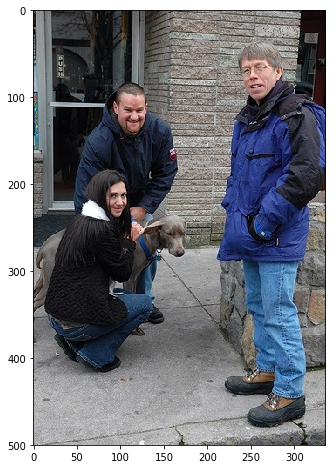

In [8]:
img = open_image(gt.filename)
img_size = Size(img.shape[1], img.shape[0])
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.show()

## Plot Ground Truth Box

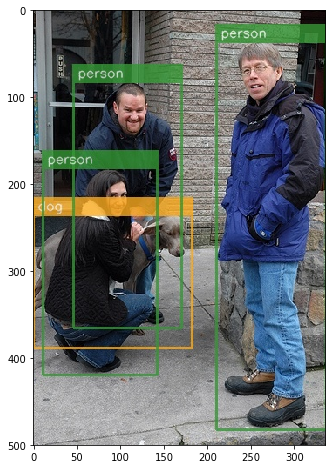

In [9]:
img = cv2.imread(gt.filename)
colors = data['colors']
for box in gt.boxes:
    draw_box(img, box, colors[box.label])
filename = os.path.join('pascal-voc/annotated', gt.filename.split('/')[-1])
cv2.imwrite(filename, img)

img = open_image(filename)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.show()

In [10]:
# plotting single bbox

img = cv2.imread(gt.filename)
img.shape

(500, 336, 3)

In [11]:
box = gt.boxes[2]
box

Box(label='person', labelid=14, center=Point(x=0.32142857142857145, y=0.447), size=Size(w=0.36904761904761907, h=0.566))

person
124.0 283.0 108.00000000000001 223.5
46 82 170 365


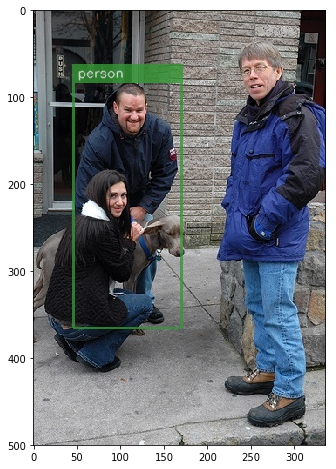

In [12]:
# convert propotional to absolute dimension of box - prob2abs

# Absolute x, y, w, h
aw = box.size.w * img.shape[1] # w of image
ah = box.size.h * img.shape[0] # h of image
cx = box.center.x * img.shape[1]
cy = box.center.y * img.shape[0]

print(box.label)
print(aw, ah, cx, cy)

# Absolute xmin, ymin, xmax, ymax
xmin = int(cx-aw/2)
xmax = int(cx+aw/2)
ymin = int(cy-ah/2)
ymax = int(cy+ah/2)
print(xmin, ymin, xmax, ymax)

# Drawing
img_box = np.copy(img)
cv2.rectangle(img_box, (xmin, ymin), (xmax, ymax), colors[box.label], 2)
cv2.rectangle(img_box, (xmin-1, ymin-20), (xmax+1, ymin), colors[box.label], cv2.FILLED)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(img_box, box.label, (xmin+5, ymin-5), font, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
alpha = 0.8 
cv2.addWeighted(img_box, alpha, img, 1.-alpha, 0, img)
test_file = 'pascal-voc/annotated/test.jpg'
cv2.imwrite(test_file, img)

img = open_image(test_file)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.show()

## Plot all anchors

In [21]:
anchors = get_anchors_for_preset(preset)
print(anchors[0])
print(len(anchors))

Anchor(center=Point(x=0.013157894736842105, y=0.013157894736842105), size=Size(w=0.1, h=0.1), x=0, y=0, scale=0.9, map=0)
8732


In [22]:
# convert prop anchors to absolute anchors - (xmin, xmax, ymin, ymax)
anchors_arr = anchors2array(anchors, Size(336, 500))
print(anchors_arr.shape)
anchors_arr[0]

(8732, 4)


array([-12.,  21., -18.,  31.])

In [23]:
def draw_annchor(img, an, colr, label):
    xmin, xmax, ymin, ymax = int(an[0]), int(an[1]), int(an[2]), int(an[3])
    img_box = np.copy(img)
    cv2.rectangle(img_box, (xmin, ymin), (xmax, ymax), colr, 2)
    #cv2.rectangle(img_box, (xmin-1, ymin-20), (xmax+1, ymin), colr, cv2.FILLED)
    #font = cv2.FONT_HERSHEY_SIMPLEX
    #cv2.putText(img_box, label, (xmin+5, ymin-5), font, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    alpha = 0.8 
    cv2.addWeighted(img_box, alpha, img, 1.-alpha, 0, img)

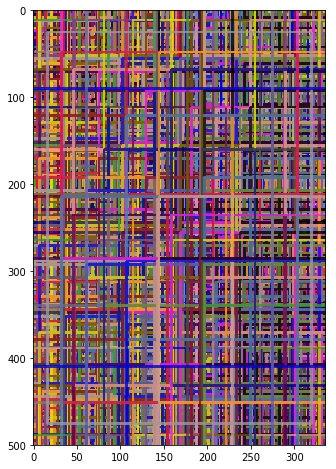

In [24]:
img = cv2.imread(gt.filename)
colors = data['colors']
cols = list(colors.values())
n_c = len(cols)

count = 0
for i, an in enumerate(anchors_arr[:]):
    draw_annchor(img, an, cols[count%n_c], str(i))
    count += 1
filename = 'pascal-voc/annotated/test_anchors.jpg'
cv2.imwrite(filename, img)

img = open_image(filename)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.show()

## Plotting good anchors based on jaccard overlap

In [28]:
def jaccard_overlap(box_arr, anchors_arr):
    # box_arr: (4,)
    # anchors_arr: (batch_size, 4)
    
    # Area of all anchors: (batch_size)
    areaa = (anchors_arr[:, 1]-anchors_arr[:, 0]+1) * (anchors_arr[:, 3]-anchors_arr[:, 2]+1)                             
    # Area of the box: Scalar
    areab = (box_arr[1]-box_arr[0]+1) * (box_arr[3]-box_arr[2]+1)                                                                                                   
    
    # Compute cooridinate for intersection box
    xxmin = np.maximum(box_arr[0], anchors_arr[:, 0])                           
    xxmax = np.minimum(box_arr[1], anchors_arr[:, 1])                           
    yymin = np.maximum(box_arr[2], anchors_arr[:, 2])                           
    yymax = np.minimum(box_arr[3], anchors_arr[:, 3])
    
    # if not intersection w and h can be negative
    w = np.maximum(0, xxmax-xxmin+1)                                            
    h = np.maximum(0, yymax-yymin+1)                                            
    intersection = w*h                                                          
    union = areab+areaa-intersection                                            
    return intersection/union 

def compute_overlap(box_arr, anchors_arr, threshold):
    # iou: shape (N)
    iou = jaccard_overlap(box_arr, anchors_arr)
    # mask the all the iou > threshold 
    overlap = iou > threshold                                                   
    
    # select all the index of anchor, iou > threshold
    good_idxs = np.nonzero(overlap)[0]
    
    # select the best anchor, highest iou
    best_idx  = np.argmax(iou)                                                  
    best = None                                                                 
    good = []                                                                   
                                                                                 
    if iou[best_idx] > threshold:
        best = Score(best_idx, iou[best_idx])                                   
                                                                                 
    for idx in good_idxs:                                                       
        good.append(Score(idx, iou[idx]))                                       
                                                                             
    return Overlap(best, good)

In [30]:
# For every box compute the best match and all the matches above 0.5 Jaccard overlap
overlaps = {}
for box in gt.boxes:
    box_arr = box2array(box, img_size)
    overlaps[box] = compute_overlap(box_arr, anchors_arr, 0.5)
overlaps[gt.boxes[0]] # best and good overlapped

Overlap(best=Score(idx=8104, score=0.7759923742084837), good=[Score(idx=8003, score=0.5116279069767442), Score(idx=8004, score=0.6017846153846154), Score(idx=8005, score=0.6017846153846154), Score(idx=8094, score=0.5549329359165425), Score(idx=8103, score=0.5443105597435746), Score(idx=8104, score=0.7759923742084837), Score(idx=8105, score=0.637259517308477), Score(idx=8203, score=0.5092297899427116), Score(idx=8204, score=0.6262833675564682), Score(idx=8205, score=0.5829447035309794), Score(idx=8494, score=0.5992217898832685), Score(idx=8495, score=0.530802466139133), Score(idx=8504, score=0.5992217898832685), Score(idx=8505, score=0.530802466139133), Score(idx=8553, score=0.5076503043057846), Score(idx=8558, score=0.51266930451986)])

In [32]:
# Set up the training vector resolving conflicts in favor of a better match

vec = np.zeros((len(anchors), 20+1+4), dtype=np.float32)

vec[:, 20] = 1     # bg class 20th
vec[:, 20+1] = 0   # x offset
vec[:, 20+2] = 0   # y offset
vec[:, 20+3] = 0   # log width scale
vec[:, 20+4] = 0   # log height scale

In [33]:
def process_overlap(overlap, box, anchor, matches, num_classes, vec):           
    if overlap.idx in matches and matches[overlap.idx] >= overlap.score:        
        return                                                                  
    matches[overlap.idx] = overlap.score                                        
    vec[overlap.idx, 0:num_classes+1] = 0                                       
    vec[overlap.idx, box.labelid]     = 1                                       
    vec[overlap.idx, num_classes+1:]  = compute_location(box, anchor)       

In [34]:
matches = {}
for box in gt.boxes:
    for overlap in overlaps[box].good:
        anchor = anchors[overlap.idx]
        process_overlap(overlap, box, anchor, matches, 20, vec)

In [35]:
good_anchors = []
box = gt.boxes[3]
for overlap in overlaps[box].good:
    good_anchors.append(anchors[overlap.idx])
len(good_anchors)

12

In [36]:
good_ann_arr = anchors2array(good_anchors, img_size)
good_ann_arr.shape

(12, 4)

All good anchors for person class


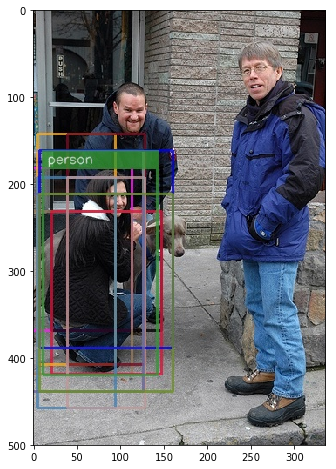

In [38]:
img = cv2.imread(gt.filename)
colors = data['colors']
cols = list(colors.values())
n_c = len(cols)

count = 0
for i, an in enumerate(good_ann_arr):
    draw_annchor(img, an, cols[count%n_c], str(i))
    count += 1
draw_box(img, box, colors[box.label])
filename = 'pascal-voc/annotated/test_good_anchors.jpg'
cv2.imwrite(filename, img)

print('All good anchors for {} class'.format(box.label))
img = open_image(filename)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.show()

## Plotting Best anchors based on jaccard overlap

In [39]:
best_anchor = anchors[overlaps[box].best.idx]
xmin, xmax, ymin, ymax = prop2abs(anchor.center, anchor.size, img_size)
best_anchor_arr = np.array([xmin, xmax, ymin, ymax])
best_anchor_arr.shape

(4,)

Best anchor for person class


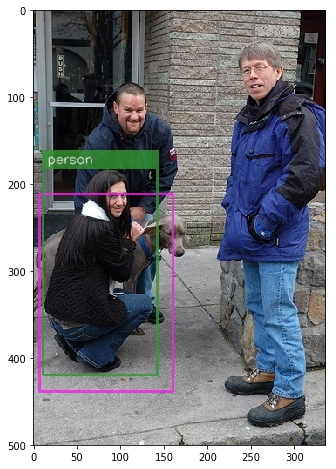

In [41]:
img = cv2.imread(gt.filename)

draw_annchor(img, best_anchor_arr, cols[0], 'best')
draw_box(img, box, colors[box.label])
filename = 'pascal-voc/annotated/test_best_anchor.jpg'
cv2.imwrite(filename, img)

print('Best anchor for {} class'.format(box.label))
img = open_image(filename)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.show()

# Testing on cone datasets

In [67]:
import os, sys
import json
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
from utils import get_filenames_and_labels, Size
from ssdutils import abs2prop, get_anchors_for_preset, get_preset_by_name, anchors2array, compute_overlap, box2array

In [133]:
def prop2abs(an, img_size):
    """
    Convert prop center-width bounds to absolute min-max bounds.
    """
    x, y, w, h = an[0], an[1], an[2], an[3]
    aw = w*img_size.w/2
    ah = h*img_size.h/2
    cx = x*img_size.w
    cy = y*img_size.h

    return int(cx-aw), int(cx+aw), int(cy-ah), int(cy+ah)

def draw_box(img, box, label, color, box_type='gt_box'):
    img_size = Size(img.shape[1], img.shape[0])
    if box_type is not 'gt_box':
        xmin, xmax, ymin, ymax = int(box[0]), int(box[1]), int(box[2]), int(box[3])
        w = 1
    else:
        xmin, xmax, ymin, ymax = prop2abs(box, img_size)
        print(xmin, xmax, ymin, ymax)
        w = 2
    img_box = np.copy(img)
    cv2.rectangle(img_box, (xmin, ymin), (xmax, ymax), color, w)
    #cv2.rectangle(img_box, (xmin-1, ymin-20), (xmax+1, ymin), color, cv2.FILLED)
    #font = cv2.FONT_HERSHEY_SIMPLEX
    #cv2.putText(img_box, label, (xmin+5, ymin-5), font, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    alpha = 0.8 
    cv2.addWeighted(img_box, alpha, img, 1.-alpha, 0, img)

In [17]:
data_dir = '../dataset/'
image_dir = os.path.join(data_dir, 'Images')
label_dir = os.path.join(data_dir, 'Labels')

In [18]:
train_filenames, train_labels = get_filenames_and_labels(image_dir, label_dir, 'train')

In [19]:
filename = train_filenames[322]
filename

'../dataset/Images/144_cam-image_array_.jpg'

In [20]:
gt = train_labels[322]
gt

[(array([0.58778617, 0.11320326, 0.11668644, 0.16719251]), 0),
 (array([0.90649689, 0.15151821, 0.1375855 , 0.19854111]), 0),
 (array([0.22220236, 0.09973439, 0.06893406, 0.09680103]), 0),
 (array([0.38720411, 0.09020096, 0.10560112, 0.12466799]), 1)]

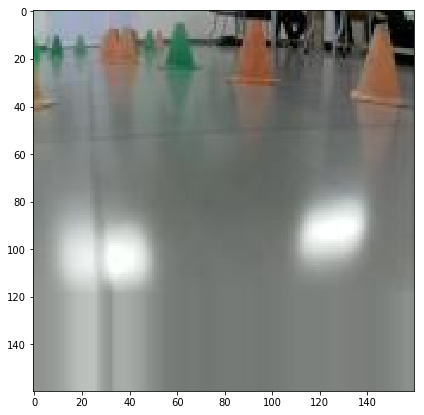

In [21]:
img = open_image(filename)
plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.show()

(160, 160, 3)


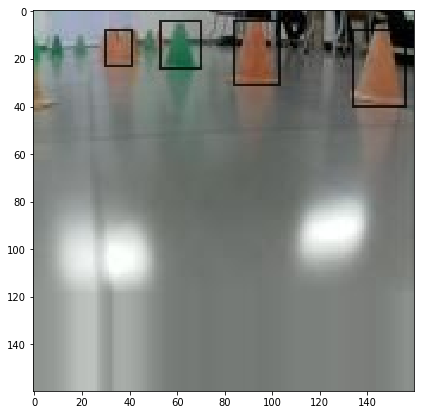

In [38]:
img = cv2.imread(filename)
print(img.shape)
for box, label in gt:
    draw_box(img, box, str(label), (1, 1, 1))
test_file = 'images/test.jpg'
cv2.imwrite(test_file, img)

img = open_image(test_file)
plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.show()

## Plot all the anchors

In [35]:
colors_rgb = [(0, 0, 0), (111, 74, 0), (81, 0, 81), (128, 64, 128), (244, 35, 232), (230, 150, 140),
          ( 70,  70,  70), (102, 102, 156), (190, 153, 153), (150, 120,  90)]
colors = [(t[2], t[1], t[0]) for t in colors_rgb]

In [31]:
img_size = Size(img.shape[1], img.shape[0])
preset = get_preset_by_name('ssdmobilenet160')
anchors = get_anchors_for_preset(preset)
anchors_arr = anchors2array(anchors, img_size)
anchors_arr[0], len(anchors_arr)

(array([-22.,  38., -22.,  38.]), 790)

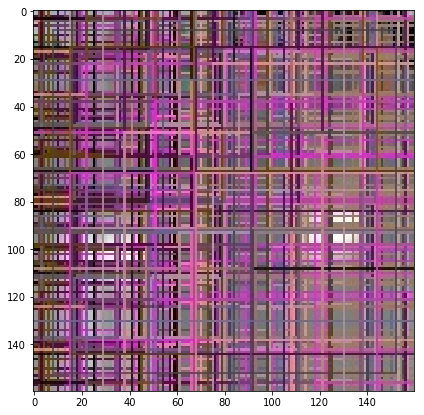

In [107]:
img = cv2.imread(filename)
n_c = len(colors)

# select top 10 smallest and largest anchor boxes
# top = 20
# anchors_arr_bounds = anchors_arr[:top] + anchors_arr[-top:]
count = 0
for i, an in enumerate(anchors_arr):
    draw_box(img, an, str(i), colors[count%n_c] , box_type='anchor')
    count += 1
test_file = 'images/test_anchors.jpg'
cv2.imwrite(test_file, img)

img = open_image(test_file)
plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.show()

## Plot the all the good anchor box

In [97]:
overlaps = []
for box, _ in gt:
    box_arr = box2array(box, img_size)
    overlaps.append(compute_overlap(box_arr, anchors_arr, 0.2))
print(overlaps)

[(array([], dtype=int64), array([], dtype=float64)), (array([ 18,  19, 117, 118, 119, 217, 218, 219, 308, 309, 318, 319, 328,
       329, 409, 419, 429, 439]), array([0.20397743, 0.20397743, 0.2005814 , 0.2005814 , 0.2005814 ,
       0.20272436, 0.20272436, 0.20272436, 0.20294118, 0.20294118,
       0.20294118, 0.20294118, 0.20294118, 0.20294118, 0.20469256,
       0.20469256, 0.20469256, 0.20272436])), (array([], dtype=int64), array([], dtype=float64)), (array([], dtype=int64), array([], dtype=float64))]


4 [109. 194.   2.  45.]
14 [134. 169. -43.  59.]
134 156 8 40


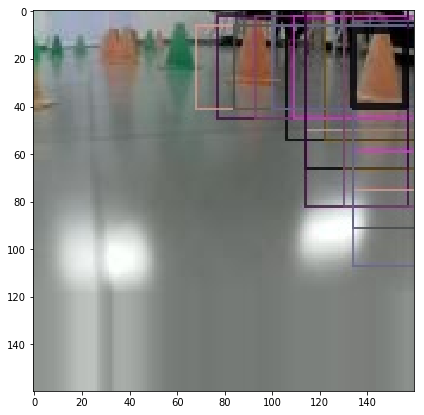

In [137]:
img = cv2.imread(filename)
n_c = len(colors)

# select top 10 smallest and largest anchor boxes
# top = 20
# anchors_arr_bounds = anchors_arr[:top] + anchors_arr[-top:]
count = 0
for i, idx in enumerate(overlaps[1][0]):
    if colors[count%n_c] == (232, 35, 244):
        print(i, anchors_arr[idx])
    draw_box(img, anchors_arr[idx], str(idx), colors[count%n_c] , box_type='anchor')
    count += 1
draw_box(img, gt[1][0], '', colors[0])
test_file = 'images/good_anchors.jpg'
cv2.imwrite(test_file, img)

img = open_image(test_file)
plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.show()

# Plotting the Best anchor

In [135]:
best_idx = np.argmax(overlaps[1][1])
print(best_idx)
best_anchor = anchors_arr[4]
best_anchor = [134., 169., -43.,  59.]

14


134 156 8 40


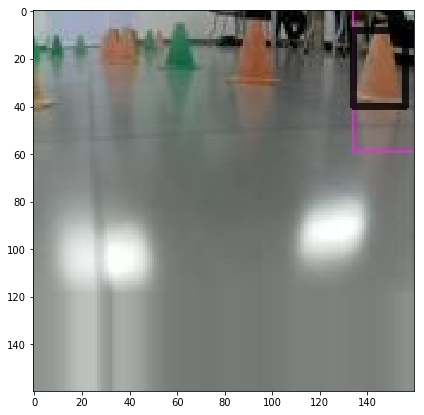

In [136]:
img = cv2.imread(filename)
draw_box(img, best_anchor, '', (232, 35, 244), box_type='anchor')
draw_box(img, gt[1][0], '', colors[0])
test_file = 'images/best_anchors.jpg'
cv2.imwrite(test_file, img)

img = open_image(test_file)
plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.show()